In [2]:
import os
import yaml
from scipy.special import expit
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from regionmask import mask_geopandas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo

plt.rcParams["font.family"] = "monospace" #

wd = "hazGAN2/projects/poweruk_winter"

with open(os.path.join(wd, "config.yaml"), "r") as stream:
    config = yaml.safe_load(stream)

regions = ["East Midlands", "West Midlands", "South West England", "South Wales"]
region_of_interest = regions[0]

season = config["sfunc"]
local_crs = config["local_crs"]


datasets = ["training", "generated"]

training = xr.open_dataset(os.path.join(
    wd, "analysis", "data", f"risk_profile_{region_of_interest.lower()}_training_{season}.nc")
)

generated = xr.open_dataset(os.path.join(
    wd, "analysis", "data", f"risk_profile_{region_of_interest.lower()}_generated_{season}.nc")
)

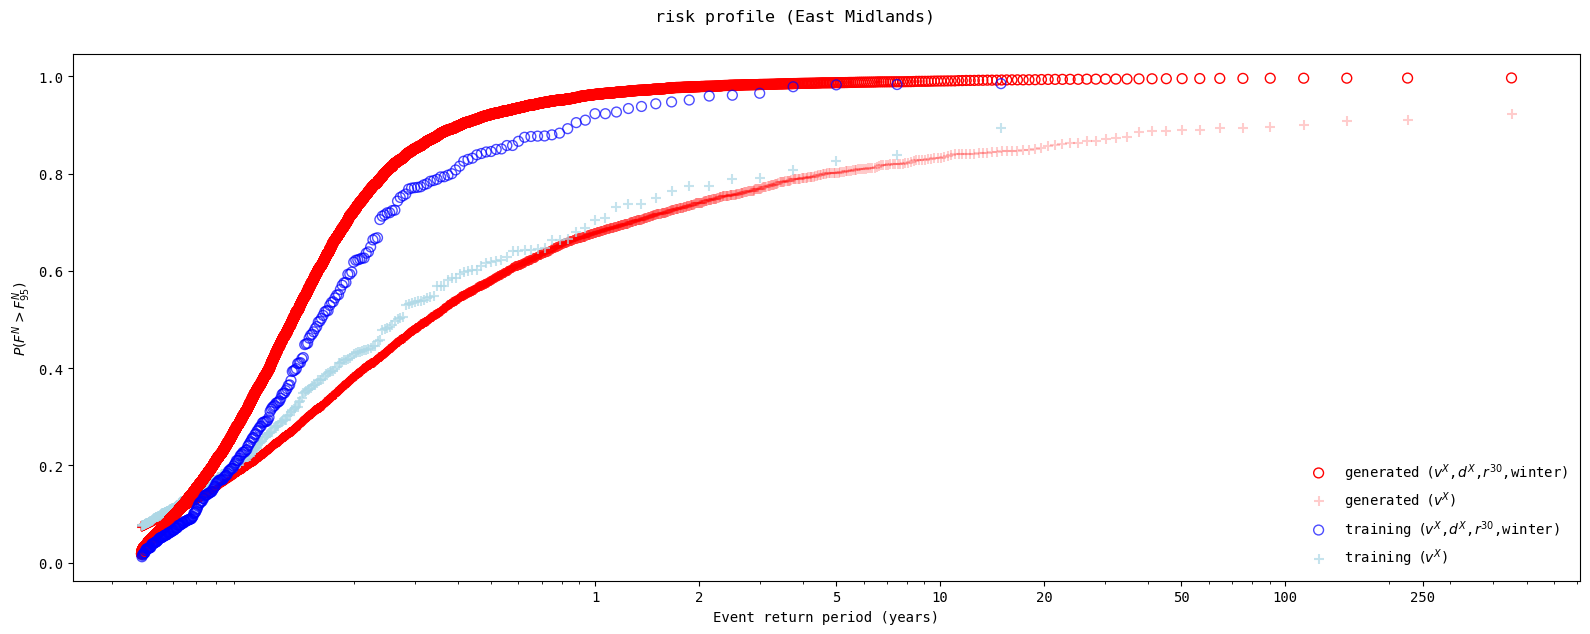

In [30]:
fig, ax = plt.subplots(1, figsize=(16, 6))

generated.plot.scatter(x="return_period", y="outage_prob", ax=ax, edgecolor="red", color="none",
                      s=50, zorder=1, marker='o', label=fr"generated $(v^X$,$d^X$,$r^{{30}}$,{season})")
generated.plot.scatter(x="base_return_period", y="base_probs", ax=ax, color="red", #color="pink",
                      s=50, alpha=0.2, zorder=0, marker='+', label=r"generated $(v^X$)")

training.plot.scatter(x="return_period", y="outage_prob", ax=ax, edgecolor="blue", color="none",
                      s=50, alpha=0.7, marker='o', zorder=1, label=fr"training $(v^X$,$d^X$,$r^{{30}}$,{season})")
training.plot.scatter(x="base_return_period", y="base_probs", ax=ax, color="lightblue",
                      s=50, alpha=0.7, marker='+', zorder=0, label=r"training $(v^X$)")

ax.set_title("")
ax.set_xscale("log")
ticks = [1, 2, 5, 10, 20, 50, 100, 250, 500, 1000]
ticks = [t for t in ticks if t <= generated.return_period[generated.return_period < np.inf].max()]
ax.set_xticks(ticks, labels=ticks)
ax.set_ylabel(r"$P(F^N>F^N_{95})$")
ax.set_xlabel("Event return period (years)")
ax.legend(loc="lower right", frameon=False)
fig.tight_layout()
# ax.set_yscale("logit")

fig.suptitle(f"risk profile ({region_of_interest})", y=1.05);

fig.savefig(os.path.join(
    wd, "results", "figures", f"riskprofiles_{region_of_interest.lower()}_{season}_both"),
           dpi=300, transparent=True, bbox_inches="tight")
